In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
from abc import ABC, abstractmethod
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

### Create DataSet Classes

In [2]:
class LoadDataSet(ABC):
    @abstractmethod
    def load_data(self):
        pass
    
class NormalizeDataSet(ABC):
    @abstractmethod
    def normalize_data(self):
        pass
    
class EncodeDataSet(ABC):
    @abstractmethod
    def encode_data(self):
        pass
    
    

In [3]:
# Load the CIFAR-10 dataset using Keras
class CifarTenLoader(LoadDataSet):
    def load_data(self):
        return cifar10.load_data()

# Normalize the pixel values to the range [0, 1].
class CifarTenNormalize(NormalizeDataSet):
    def normalize_data(self,data:np.ndarray):
        return data.reshape((data.shape[0], 32, 32, 3)).astype('float32') / 255

# One-hot encode the labels. 
class CifarTenEncode(EncodeDataSet):
    def encode_data(self,labels):
        return to_categorical(labels)

In [4]:
# Load and Preprocess the Data 
class CifarTenDataset:
    def __init__(self,data_loader:LoadDataSet,data_normalize:NormalizeDataSet,data_encode:EncodeDataSet):
        self.data_loader = data_loader
        self.data_normalize = data_normalize
        self.data_encode = data_encode
        self.train_images = None
        self.test_images = None
        self.train_labels = None
        self.test_labels = None
        
    def load_and_preprocess_data(self):
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = self.data_loader.load_data()
        self.train_images=self.data_normalize.normalize_data(self.train_images)
        self.test_images=self.data_normalize.normalize_data(self.test_images)
        self.train_labels=self.data_encode.encode_data(self.train_labels)
        self.test_labels=self.data_encode.encode_data(self.test_labels)
        return self.train_images, self.train_labels, self.test_images, self.test_labels

### Load and Preprocess the Data

In [5]:
data_loader=CifarTenLoader()
normalize_data=CifarTenNormalize()
encode_data=CifarTenEncode()

In [6]:
preprocess_data=CifarTenDataset(data_loader,normalize_data,encode_data)
train_images, train_labels, test_images, test_labels=preprocess_data.load_and_preprocess_data()

### Visualization The Data

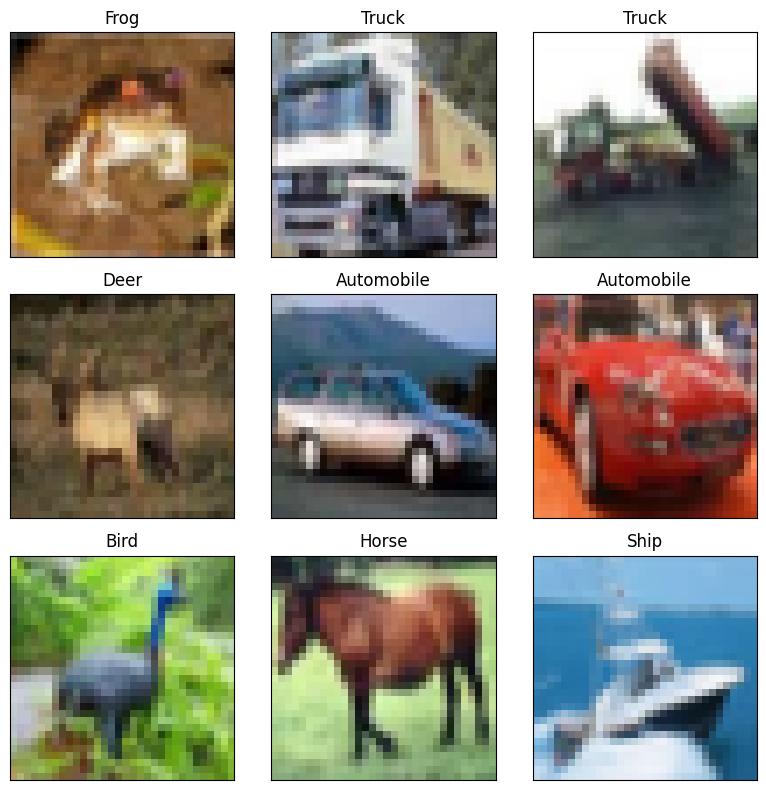

In [7]:
(images, labels), _ = data_loader.load_data()
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through images and plot
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])  # No cmap needed for RGB images
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[int(labels[i][0])])  # Fix label placement

# Adjust layout to fix spacing issues
plt.tight_layout()
plt.show()

### Create Model Classes

In [8]:
class BuildModel(ABC):
    @abstractmethod
    def build_model(self):
        pass

class TrainModel(ABC):
    @abstractmethod
    def train_model(self,model):
        pass

class EvaluateModel(ABC):
    @abstractmethod
    def evaluate_model(self,model):
        pass

In [9]:
from dataclasses import dataclass

@dataclass
class BuilderConfiguration:
    layers:list[layers.Layer]
    optimizer:str
    loss:str
    metrics:list[str]

@dataclass
class TrainConfiguration:
    train_data:np.ndarray
    train_labels:np.ndarray
    epochs:int
    batch_size:int
    validation_split:float
    callbacks:list[Callback]
    
@dataclass
class EvaluationConfiguration:
    test_data:np.ndarray
    test_labels:np.ndarray
    

In [10]:
class CNNBuilder(BuildModel):
    def __init__(self,configuration:BuilderConfiguration):
        self.configuration = configuration
    
    def build_model(self):
        model = models.Sequential(self.configuration.layers)
        model.compile(optimizer=self.configuration.optimizer,
                      loss=self.configuration.loss,metrics=self.configuration.metrics)
        
        return model

class CNNTrain(TrainModel):
    def __init__(self,configuration:TrainConfiguration):
        self.configuration = configuration
    
    def train_model(self,model):
        history = model.fit(self.configuration.train_data,self.configuration.train_labels
                                               ,epochs=self.configuration.epochs,batch_size=self.configuration.batch_size
                                               ,validation_split=self.configuration.validation_split
                                               ,callbacks=self.configuration.callbacks)
        return history

class CNNEvaluate(EvaluateModel):
    def __init__(self,configuration:EvaluationConfiguration):
        self.configuration = configuration
    
    def evaluate_model(self,model):
        test_loss, test_acc=model.evaluate(self.configuration.test_data,self.configuration.test_labels)
        return test_loss, test_acc

In [11]:
class CNNPipeline:
    def __init__(self,builder:CNNBuilder,train:CNNTrain,evaluate:CNNEvaluate):
        self.builder = builder
        self.train = train
        self.evaluate = evaluate
        self.model = None
        self.history = None
        self.test_loss = None
        self.test_acc = None
    
    def pipeline(self):
        if not self.builder.configuration:
            raise ValueError('Model configuration cannot be empty')
        if not self.train.configuration:
            raise ValueError('Training configuration cannot be empty')
        if not self.evaluate.configuration:
            raise ValueError('Evaluation configuration cannot be empty')
        
        self.model = self.builder.build_model()
        self.history = self.train.train_model(model=self.model)
        self.test_loss,self.test_acc = self.evaluate.evaluate_model(model=self.model)
        return self.model, self.history, self.test_loss, self.test_acc

### Create plot classes

In [12]:
class Visualization(ABC):
    @abstractmethod
    def visualize(self):
        pass


In [13]:
class TrainValidationAccuracy(Visualization):
    def __init__(self,history):
        self.history = history

    def visualize(self):
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

class TrainValidationLoss(Visualization):
    def __init__(self,history):
        self.history = history
    
    def visualize(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [14]:
def learning_rate_scheduler(epoch):
    initial_lr=0.001
    decay_factor=0.1
    decay_epochs=5
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return lr

lr_scheduler=LearningRateScheduler(learning_rate_scheduler)
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Build a CNN Model

In [15]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

C:\Users\GIGABYTE\Desktop\CAP\Advanced Machine Learning Topics\Assignments\Assignment-2 cnn\CNN Image Classification CIFAR10\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3599 - loss: 1.7535 - val_accuracy: 0.5130 - val_loss: 1.3384 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5859 - loss: 1.1810 - val_accuracy: 0.6248 - val_loss: 1.0791 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6479 - loss: 1.0008 - val_accuracy: 0.6465 - val_loss: 1.0280 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6781 - loss: 0.9226 - val_accuracy: 0.6525 - val_loss: 1.0111 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7053 - loss: 0.8435 - val_accuracy: 0.6656 - val_loss: 0.9693 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7605 - loss: 0.6991 - val_accuracy: 0.6985 - val_loss: 0.8817 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7686

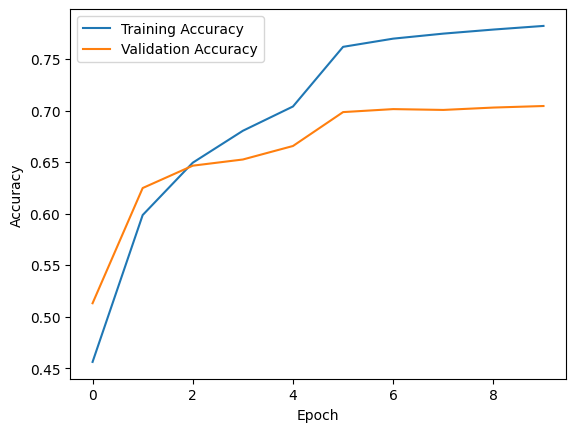

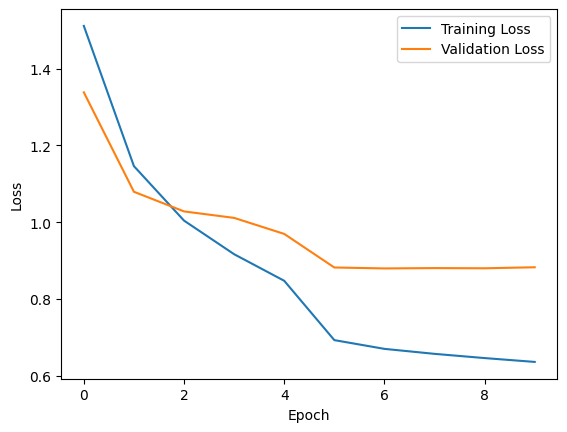

In [17]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Add dropout layers to reduce overfitting.

In [18]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=20,batch_size=16,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [19]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3049 - loss: 1.8713 - val_accuracy: 0.4853 - val_loss: 1.4530 - learning_rate: 0.0010
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4986 - loss: 1.3933 - val_accuracy: 0.5717 - val_loss: 1.2507 - learning_rate: 0.0010
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5467 - loss: 1.2745 - val_accuracy: 0.5959 - val_loss: 1.1841 - learning_rate: 0.0010
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5642 - loss: 1.2230 - val_accuracy: 0.6056 - val_loss: 1.1518 - learning_rate: 0.0010
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5802 - loss: 1.1819 - val_accuracy: 0.6139 - val_loss: 1.1249 - learning_rate: 0.0010
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6084 - loss: 1.0996 - val_accuracy: 0.6451 - val_loss: 1.0481 - learning_rate: 1.0000e-04
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy:

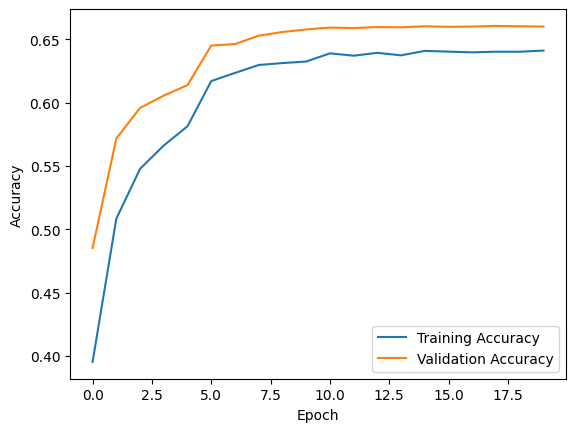

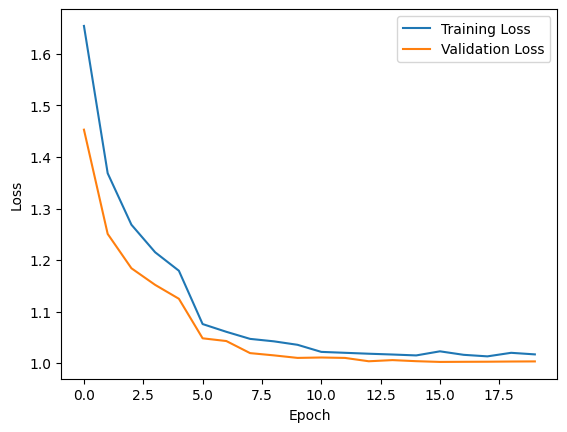

In [20]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Increase the depth (number of conv layers) or width (number of filters) of the model. 

In [21]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [22]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3052 - loss: 1.8624 - val_accuracy: 0.5300 - val_loss: 1.3129 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5454 - loss: 1.2619 - val_accuracy: 0.5986 - val_loss: 1.1421 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6220 - loss: 1.0784 - val_accuracy: 0.6458 - val_loss: 1.0150 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6670 - loss: 0.9531 - val_accuracy: 0.6523 - val_loss: 0.9880 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6989 - loss: 0.8652 - val_accuracy: 0.6514 - val_loss: 0.9894 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7530 - loss: 0.7109 - val_accuracy: 0.7059 - val_loss: 0.8642 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.765

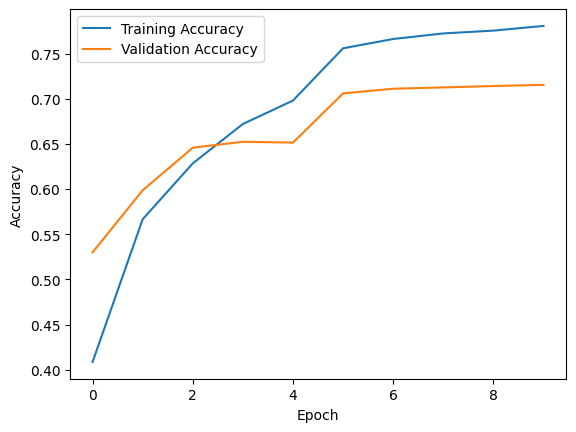

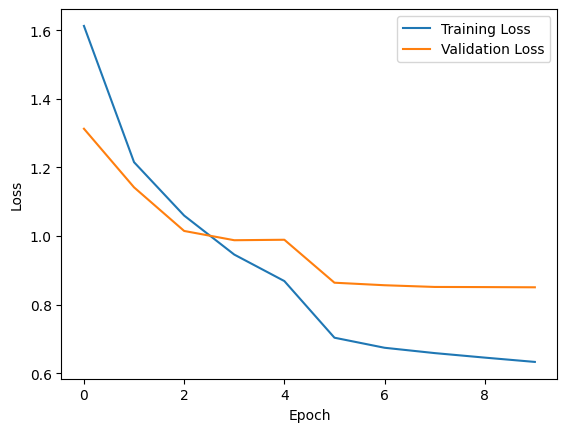

In [23]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Use data augmentation to increase the diversity of the training data.

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

build_config = BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']
)

aug_train, val_train, aug_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

builder = CNNBuilder(build_config)
model = builder.build_model()

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(aug_train, aug_labels, batch_size=32)
val_generator = val_datagen.flow(val_train, val_labels, batch_size=32)

history = model.fit(
    train_generator,
    steps_per_epoch=len(aug_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_train) // 32,
    verbose=5,
    callbacks=[lr_scheduler,early_stopping]
)

evaluate_config = EvaluationConfiguration(test_data=test_images, test_labels=test_labels)
evaluate = CNNEvaluate(evaluate_config)
test_loss, test_acc = evaluate.evaluate_model(model)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7276 - loss: 0.7986
Test loss: 0.8019374012947083
Test accuracy: 0.7245000004768372


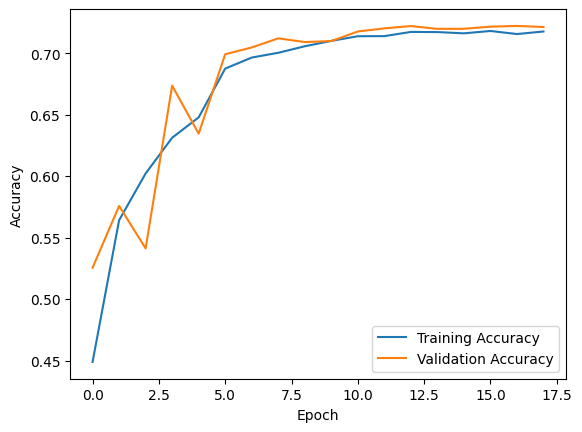

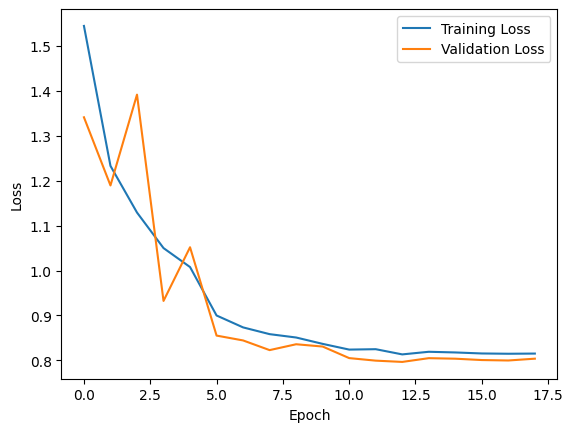

In [54]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

build_config = BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']
)

aug_train, val_train, aug_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

builder = CNNBuilder(build_config)
model = builder.build_model()

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(aug_train, aug_labels, batch_size=32)
val_generator = val_datagen.flow(val_train, val_labels, batch_size=32)

history = model.fit(
    train_generator,
    steps_per_epoch=len(aug_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_train) // 32,
    verbose=5,
    callbacks=[lr_scheduler,early_stopping]
)

evaluate_config = EvaluationConfiguration(test_data=test_images, test_labels=test_labels)
evaluate = CNNEvaluate(evaluate_config)
test_loss, test_acc = evaluate.evaluate_model(model)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7332 - loss: 0.7748
Test loss: 0.7754104733467102
Test accuracy: 0.7340999841690063


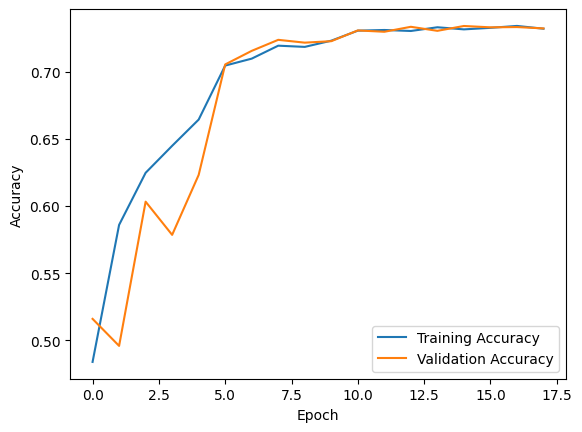

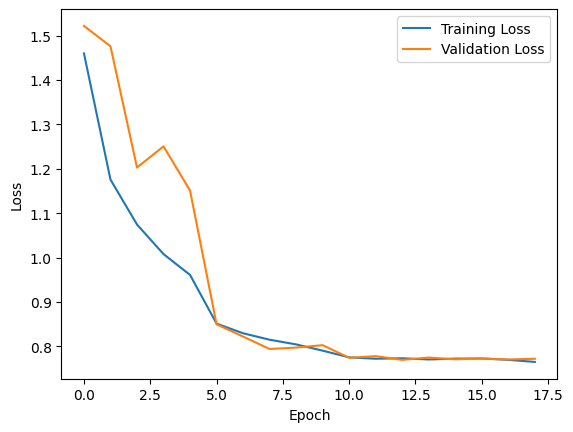

In [70]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Use adamw optimizer

In [24]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adamw",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [25]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3576 - loss: 1.7589 - val_accuracy: 0.5566 - val_loss: 1.2666 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5669 - loss: 1.2224 - val_accuracy: 0.5958 - val_loss: 1.1473 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6317 - loss: 1.0571 - val_accuracy: 0.6309 - val_loss: 1.0674 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6651 - loss: 0.9554 - val_accuracy: 0.6362 - val_loss: 1.0430 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6884 - loss: 0.8910 - val_accuracy: 0.6393 - val_loss: 1.0260 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7422 - loss: 0.7481 - val_accuracy: 0.6893 - val_loss: 0.9015 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7534

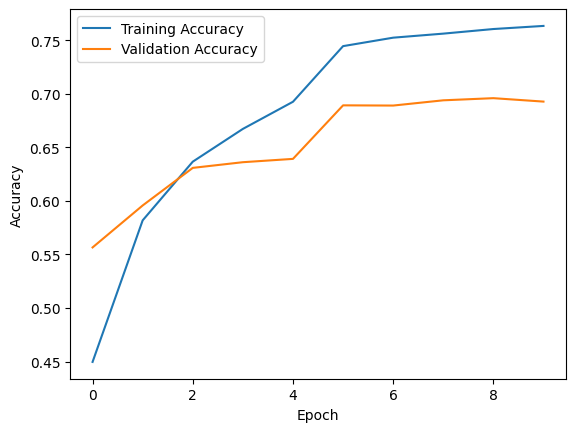

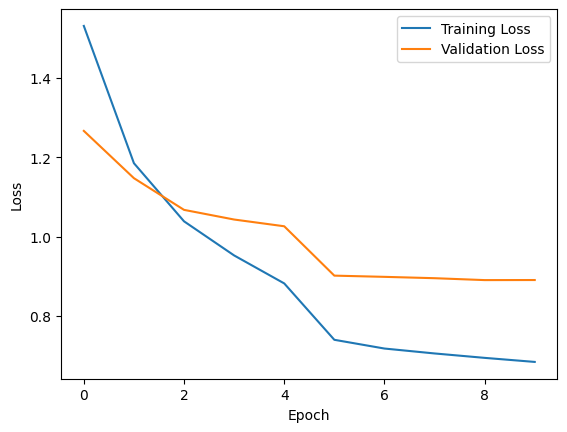

In [26]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Add batch normalization layers to stabilize training. 

In [55]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [56]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4244 - loss: 1.6310 - val_accuracy: 0.4807 - val_loss: 1.5540 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6307 - loss: 1.0482 - val_accuracy: 0.5846 - val_loss: 1.1709 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6873 - loss: 0.8895 - val_accuracy: 0.6513 - val_loss: 0.9766 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7266 - loss: 0.7795 - val_accuracy: 0.6594 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7550 - loss: 0.7032 - val_accuracy: 0.6652 - val_loss: 0.9750 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8127 - loss: 0.5514 - val_accuracy: 0.7260 - val_loss: 0.8064 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accu

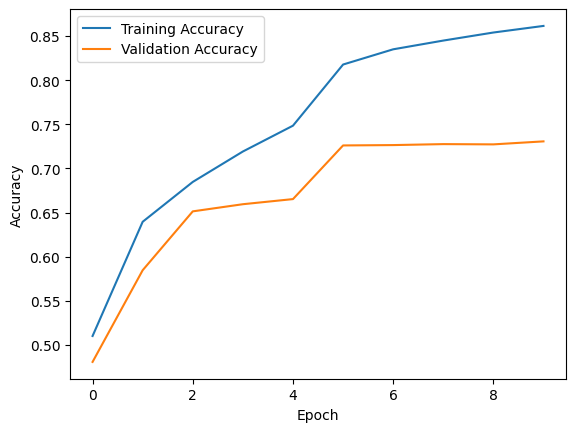

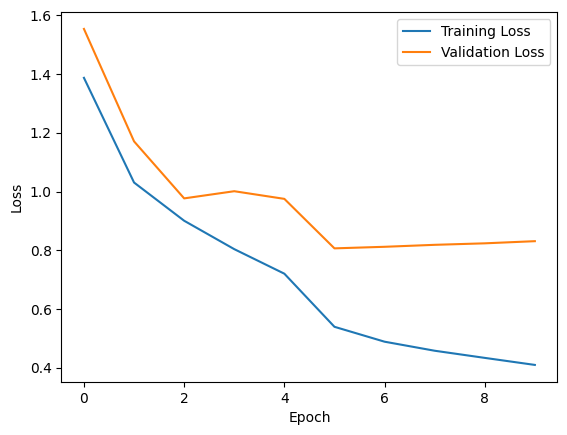

In [57]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()